<a href="https://colab.research.google.com/github/RohanBilly/AI-Menu-Generator/blob/main/AIMenuGeneratorRecovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**First, install the requirements to run the code.** This may take some time.

In [25]:
!pip install diffusers["torch"] transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

# Allows access to Huggingface AI models
from google.colab import userdata
userdata.get('HF_TOKEN')

# Allows local images to be uploaded and used
# Allows storage on Google Drive
from google.colab import drive
from google.colab import files
from PIL import Image

# Allows code to add text to the button
from PIL import Image, ImageDraw, ImageFont
import matplotlib.font_manager as fm
import shutil
import os

# Imports the AI model for image to image stable diffusion
# and allows images to be displayed in a grid
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

# Imports the AI model for text to image stable diffusion
from diffusers import StableDiffusionPipeline

# Checks if your Colab notebook is using an Nvideo GPU - this is required
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-ym8u5xu4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-ym8u5xu4
  Resolved https://github.com/huggingface/diffusers to commit 1221b28eac1801dd759e8d1df9fc9a2a998b41ed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Thu May 16 12:11:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |        

**Next, upload the button template and connect Google Drive** (template should be 800wX488h)

Saving ButtonTemplate.png to ButtonTemplate (2).png


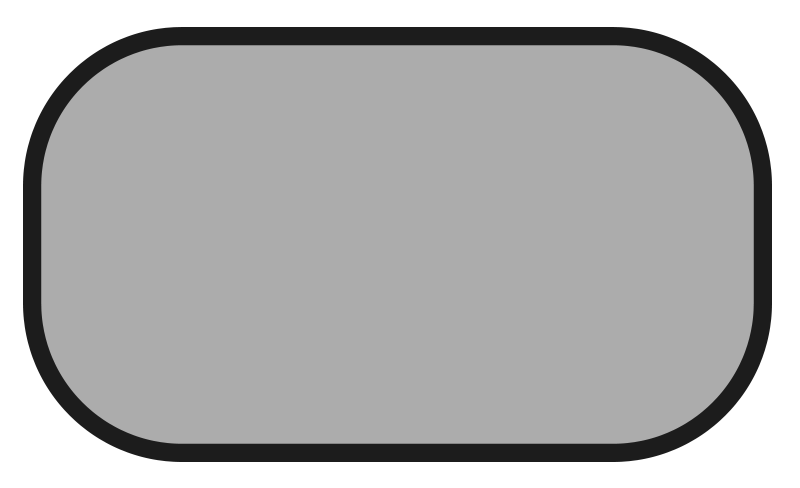

In [26]:
uploaded = files.upload()

image_path = 'ButtonTemplate.png'

# Open the image
ButtonTemplate = Image.open(image_path)

ButtonTemplate

**Add your chosen words to the buttons**

<ipython-input-27-03f4ff58ef5a>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text,font=font)
<ipython-input-27-03f4ff58ef5a>:38: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


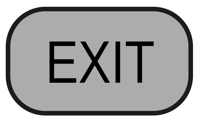

In [27]:
# Ether the words you want displayed on your buttons here
# Use as many as you like, make sure they are seperated
# with commas and contained within inverted commas:
# ['PLAY','EXIT','OPTIONS']
ButtonStrings = ['EXIT']

# Copies the button template and adds the chosen words to each copy
buttons = [ButtonTemplate.copy() for i in range(len(ButtonStrings))]

buttonIndex = 0
for button in buttons:
  draw = ImageDraw.Draw(button)
  fontIndex = 2
  text = ButtonStrings[buttonIndex]
  buttonIndex += 1

  # Chose a font available in Colab environment
  font_path = fm.findSystemFonts()
  # Using the first font found, you can change the index if needed
  font = ImageFont.truetype(font_path[fontIndex],240)
  text_width, text_height = draw.textsize(text,font=font)

  # Calculate the position to center the text
  image_width,image_height = ButtonTemplate.size
  if text_width > 700:
    font = ImageFont.truetype(font_path[fontIndex],220)
  if text_width > 800:
    font = ImageFont.truetype(font_path[fontIndex],190)
  if text_width > 950:
    font = ImageFont.truetype(font_path[fontIndex],170)
  if text_width > 1050:
    font = ImageFont.truetype(font_path[fontIndex],155)
  if text_width > 1150:
    font = ImageFont.truetype(font_path[fontIndex],125)
  if text_width > 1250:
    font = ImageFont.truetype(font_path[fontIndex],100)

  text_width, text_height = draw.textsize(text, font=font)
  position = ((image_width - text_width) / 2, (image_height - text_height - 50) / 2)

  text_color = (0,0,0)

  draw.text(position, text, font=font, fill = text_color)
  # button = button.resize((200,122))

# Resizes the buttons to reduce processing time and stay within the GPU RAM limits of Google Colab
for i in range (0,len(buttons)):
  buttons[i] = buttons[i].resize((200,122))
  # buttons[i] = buttons[i].resize((362,220))   USE THIS LINE FOR HIGHER QUALITY IMAGES

# Display button templates
make_image_grid(buttons, rows=1, cols=len(buttons))




**Runs the buttons through the Stable Diffusion model with chosen parameters** - Customise the parameters below and rerun the cell if you arent happy with your results

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

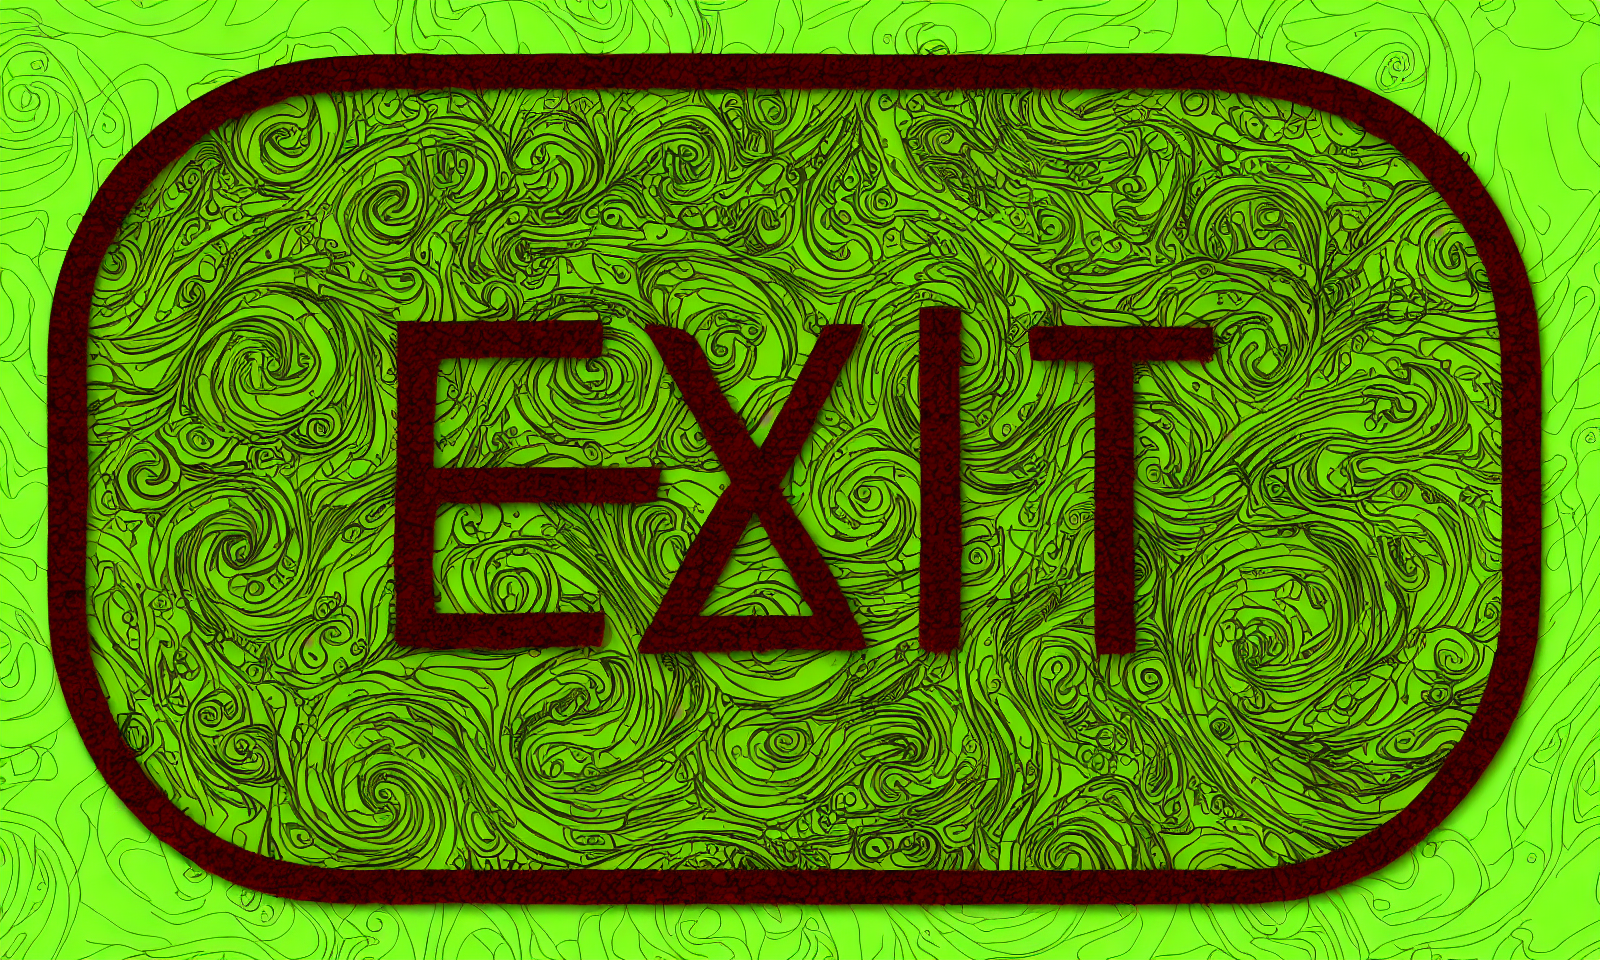

In [28]:
# Import the stable diffusion model
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant = "fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()
pipeline.safety_checker = None

# PARAMETERS - Change these to effect the end result

# Prompts direct the model on what to do with the original image
prompt = "psychedelic theme, keep the white border, multicolour"
negativePrompt = "green"

# Tells the model how closely to stick to the original picture
# (0 to 1, 1 essentially ignores the original image)
strength = 0.68

# Tells the model how closely to follow the text prompt (15)
guidance = 10

# Number of denoising steps, will increase the processing time
# but produce a better looking result
interferenceSteps = 25

#Display the images
for i in range(0,len(buttons)):
  buttons[i] = pipeline(prompt, image=buttons[i], strength = strength, num_interference_steps = interferenceSteps, guidance_scale = guidance, negative_prompt = negativePrompt).images[0]
make_image_grid(buttons, rows = 1, cols = len(buttons))

**Use this next cell to make the menu background** - it produces an image based on your prompt.

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

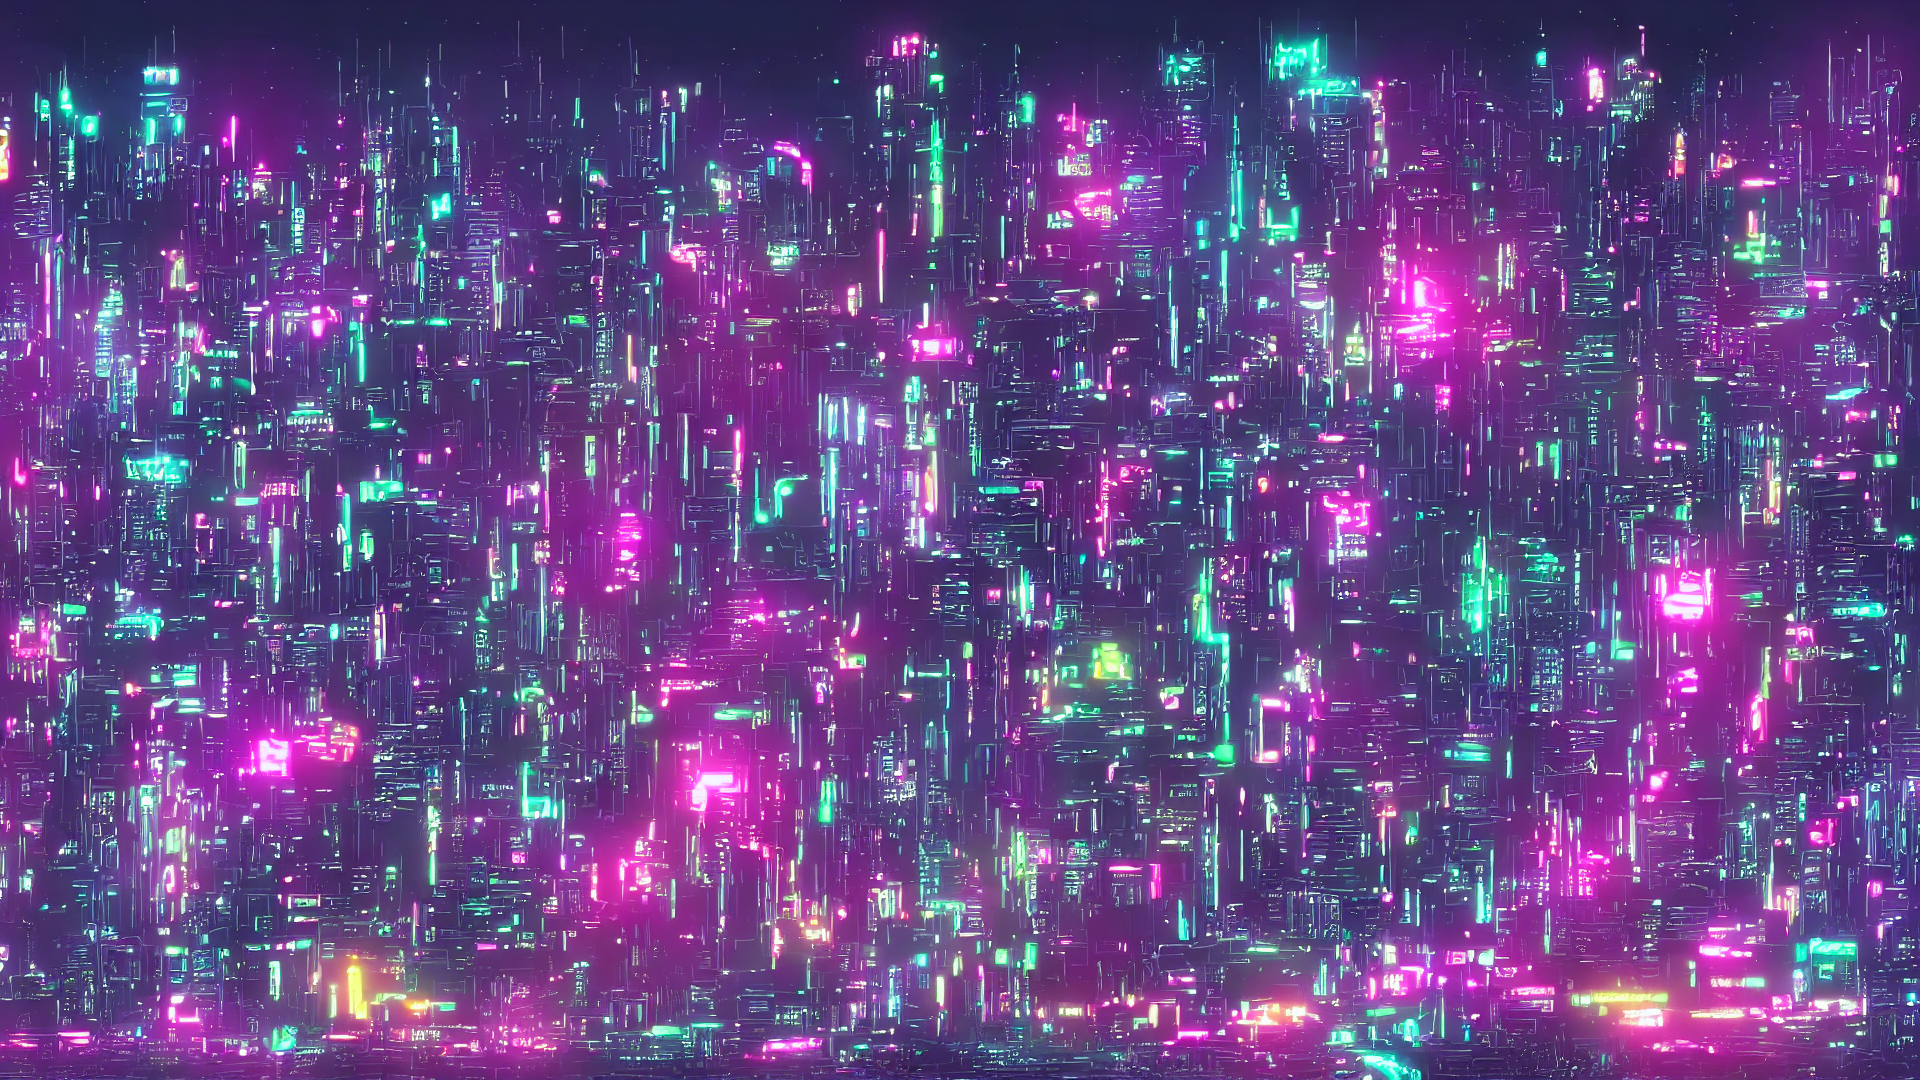

In [9]:
#import stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
pipe.safety_checker = None

#enter parameters
prompt = "dark futuristic city, neon lights, not overcomplicated, simplistic, background"
height = 1080
width = 1920
steps = 25
guidance = 7.5
negativePrompt = "blurry, boring, complex"

#produce and display image
image = pipe(prompt, height=height, width=width,
             num_interference_steps = steps,
             guidance_scale = guidance,
             negative_prompt = negativePrompt).images[0]
image